In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/lawsdiv`


In [2]:
using DataFrames, DataFramesMeta, GLM
using Statistics, StatsBase
using NFFT
using FHist
using Plots
using Random, Distributions, SpecialFunctions, LsqFit
using DifferentialEquations

In [3]:
include("./script.jl")
using .PlotDistributions

# Models definition

In [4]:
function exp_growth(S, y0, Δt, n; σ=1.0, p=0.95)

    S, n = Int64(S), Int64(n)
    y = zeros(n,S)
    y[1,:] .= y0
    for i in 2:n
        gamma = abs.(1 .+ rand(Normal(0, σ), S))
        growth = y[i-1,:] .* exp.(log.(gamma) .* Δt)
        intro = zeros(S)
        if rand() > p
            intro .+= rand()
        end
        y[i,:] = growth .+ intro
    end

    return y
end;

function logistic_growth(S, y0, Δt, n; r=1.0, K=1000 .* ones(S), σ=1.0)
    # Logistic ODE (drift)
    function logistic!(du, u, p, t)
        r, K, σ = p
        du .= r .* u .* (1 .- u ./ K)
    end

    # Diffusion term (multiplicative noise)
    function diffusion!(du, u, p, t)
        σ = p[3]
        du .= σ .* u
    end

    # Callback to clip negative values to zero
    function condition(u, t, integrator)
        any(u .< 0)  # trigger when any component is negative
    end

    function affect!(integrator)
        integrator.u .= max.(integrator.u, 0.0)
    end

    cb = DiscreteCallback(condition, affect!)

    # Problem definition
    tspan = (0.0, n * Δt)
    p = (r, K, σ)
    prob = SDEProblem(logistic!, diffusion!, y0, tspan, p)

    # Solve with callback
    sol = solve(prob, SRIW1(), callback=cb, saveat=Δt)

    # Return solution as matrix (rows = time steps, columns = variables)
    return reduce(hcat, sol.u)'
end;

# Distributions

In [5]:
model = exp_growth

exp_growth (generic function with 1 method)

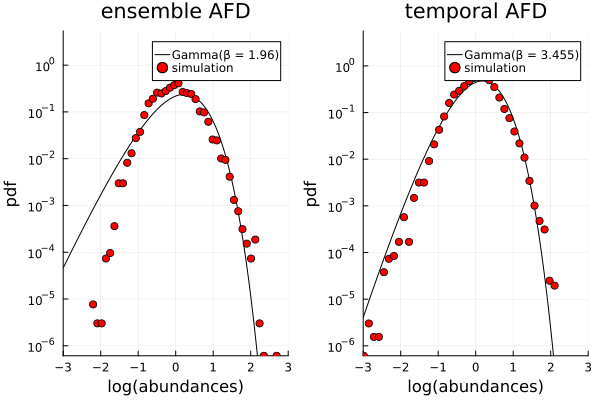

In [6]:
Random.seed!(42)
N_species = 5000
Δt = 0.1
n = 10000
params = [N_species, Δt, n]
AFD = PlotDistributions.AFD(model, params;
        y0 = 100.0, temporal=true, ensemble=true, skip=1,
        Δb=0.1, plot_fig=true, save_plot=false, plot_name="AFD.png", p=0.7)

display(AFD["fig"])

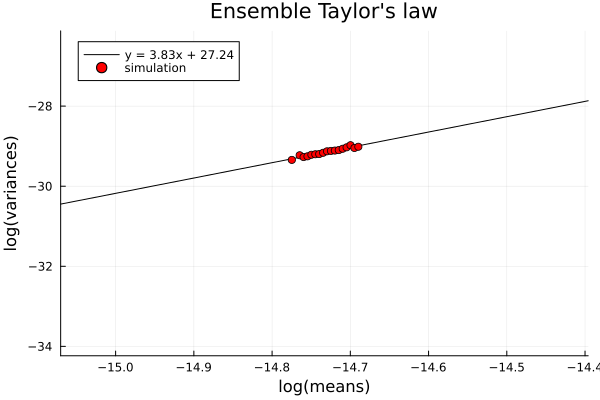

In [7]:
Random.seed!(1234)
N_species = 5000
Δt = 0.1
n = 10000
params = [N_species, Δt, n]
TAYLOR = PlotDistributions.Taylor(model, params;
        y0 = 100.0, temporal=false, ensemble=true, skip=1, n_ens=5000, S_reduce=10, n_reduce=100,
        Δb=0.005, plot_fig=true, save_plot=false, plot_name="Taylor.png", p=0.7)

display(TAYLOR["fig"])

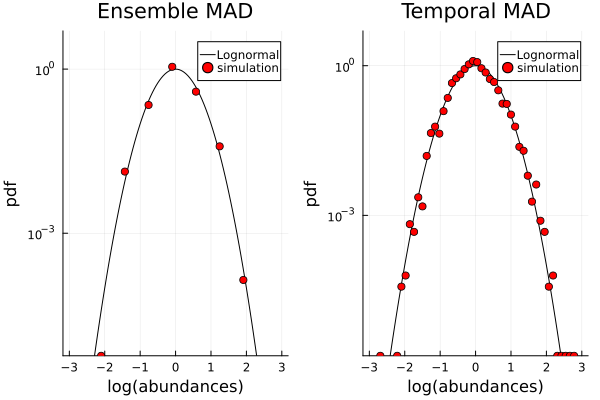

In [8]:
Random.seed!(1234)
N_species = 5000
Δt = 0.1
n = 10000
params = [N_species, Δt, n]
MAD = PlotDistributions.MAD(model, params;
        y0 = 100.0, temporal=true, ensemble=true, skip=1, n_ens=5000, S_reduce=10, n_reduce=100,
        Δb=0.01, plot_fig=true, save_plot=false, plot_name="MAD.png", p=0.7)

display(MAD["fig"])

In [256]:
# Random.seed!(1234)

# # Set parameters
# N_species = 5000
# y0 = ones(N_species)
# Δt = 0.1
# n = 5000
# r = 1.0
# K = 100 .* ones(N_species)
# noise_strength = 1.0

# # Simulate  dynamics
# y = logistic_growth(N_species, y0, Δt, n-1; r=r, K=K, σ=noise_strength)

# # Sample at larger timesteps
# skip = 1
# y = y[1:skip:end, :]

# # Normalize entries
# y ./= sum(y, dims=2)

# # Save results into a DataFrame
# df = DataFrame(
#     time = repeat(1:n, inner=N_species),
#     variable = repeat(1:N_species, outer=n),
#     value = vec(permutedims(y)),
#     log_value = vec(permutedims(log10.(y)))
# )

# df_filtered = df[df.value .> 0.0, :];

In [12]:
Random.seed!(1234)

# Set parameters
N_species = 5000
y0 = 100.0 .* ones(N_species)
Δt = 0.1
n = 5000
p = 0.9

# Simulate  dynamics
y = exp_growth(N_species, y0, Δt, n; σ=1.0, p=p)

# Sample at larger timesteps
skip = 1
y = y[1:skip:end, :]

# Normalize entries
y ./= sum(y, dims=2)

log_data = [mean(log.(y[:,i][y[:,i] .> 0.0])) for i in 1:length(y[1,:])]

# Save results into a DataFrame
# df = DataFrame(
#     time = repeat(1:n, inner=N_species),
#     variable = repeat(1:N_species, outer=n),
#     value = vec(permutedims(y)),
#     log_value = vec(permutedims(log10.(y)))
# )

# df_filtered = df[df.value .> 0.0, :];

5000-element Vector{Float64}:
 -8.605465070661907
 -8.540757430086256
 -8.537345640537058
 -8.533034380717686
 -8.572214096634275
 -8.556712635480709
 -8.588260025097918
 -8.567587985996079
 -8.57969267467607
 -8.594138237439966
 -8.543825281306857
 -8.574024709648318
 -8.54991626337545
  ⋮
 -8.560343942003474
 -8.546034006886826
 -8.544845221534779
 -8.566636135259374
 -8.577379066222175
 -8.593459290151033
 -8.59282818316889
 -8.563756661474601
 -8.556893647902628
 -8.530384321074923
 -8.567552174426815
 -8.550581852754336

In [16]:
bmin = round(minimum(log_data))
bmax = round(maximum(log_data))
println(bmin)
println(bmax)

-9.0
-8.0


In [151]:
# Random.seed!(1234)

# # Set parameters
# N_species = 5000
# y0 = 100.0 .* ones(N_species)
# n = 5000
# Δt = 1
# p = 0.95
# gamma = 2.0

# # Simulate  dynamics
# y = exp_jump(N_species, y0, n; gamma=gamma, p=p)

# # Sample at larger timesteps
# skip = 1
# y = y[1:skip:end, :]

# # Normalize entries
# y ./= sum(y, dims=2)

# # Save results into a DataFrame
# df = DataFrame(
#     time = repeat(1:n, inner=N_species),
#     variable = repeat(1:N_species, outer=n),
#     value = vec(permutedims(y)),
#     log_value = vec(permutedims(log10.(y)))
# )

# df_filtered = df[df.value .> 0.0, :];

5000
5000


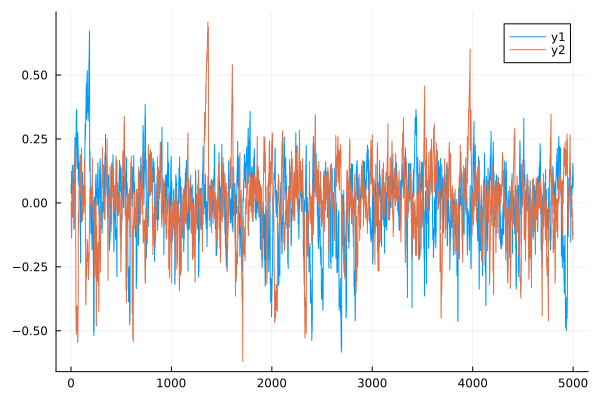

In [152]:
ddf = sort(df_filtered, :time);
variables = unique(ddf.variable)
idx1, idx2 = 1, 20

ts1 = ddf[ddf.variable .== variables[idx1],:].log_value
ts2 = ddf[ddf.variable .== variables[idx2],:].log_value

ts1 .-= mean(ts1)
ts2 .-= mean(ts2)

times1 = ddf[ddf.variable .== variables[idx1],:].time
times2 = ddf[ddf.variable .== variables[idx2],:].time

println(length(times1))
println(length(times2))

plot(times1, ts1)
plot!(times2, ts2)

# Power Spectrum Density analysis

In [153]:
function window_correction(window)
    # Helper function to avoid odd number of time steps which creates problems for FFT
    while (maximum(window) - minimum(window)) % 2 != 0
        if length(window) <= 1
            break  # Can't reduce further
        end
        window = window[1:end-1]  # Remove the last element
    end
    return window
end

function consecutive_window(data::Vector{<:Integer}, n::Integer = 0)
    if isempty(data)
        return Integer[]
    end
    out1 = [data[1]]
    out2 = Integer[]
    for (i, d) in enumerate(data[2:end])
        if d - out1[end] <= n + 1
            push!(out1, d)
        else
            out2 = consecutive_window(data[i+1:end], n)
            break
        end
    end
    return length(out1) >= length(out2) ? window_correction(out1) : window_correction(out2)
end

# Find the largest time window considering a maximum gap of 'daygap' days
daygap = 0
unique_days = unique(df_filtered.time)
sort!(unique_days)
window = consecutive_window(unique_days, daygap)
if length(window) % 2 != 0
    window = window[1:end-1]
end

println(length(window))

# Filter to consider only rows with experiment_day in the selected window and reorder them
df_subset = filter(row -> in(row.time, window), df_filtered)
sort!(df_subset, :time);

4998


In [154]:
# Set paramas and variables to perform NFFT
# N = Int64(maximum(window) - minimum(window))
N = length(window)
N_min = N / 2 # The analysis will consider only those species that are present in a 'sufficient' number of samples
fs = 1 / (skip*Δt)
Nf = fs / 2 # Since sample rate is 1 day
frequencies = (-Int(floor(N/2)):Int(floor(N/2) - 1)) * fs / N # Frequency domain

println("Window length:  $N")

mean_S = zeros(N) # Initialize array
otu_count = 0 # Needed for normalization
otu_ids = unique(df_subset.variable)[1:200]
df_filtered = filter(:variable => in(otu_ids), df_subset)
grouped = groupby(df_filtered, :variable)

for otu in otu_ids
    group = grouped[otu]

    t_indices = collect(group.time)
    t_normalized = (t_indices .- minimum(window)) ./ N .- 0.5

    x = collect(group.log_value)
    x .-= mean(x)

    if length(t_indices) > N_min
        otu_count += 1
        p_nfft = NFFT.plan_nfft(t_normalized, N, reltol=1e-9)
        fhat = adjoint(p_nfft) * x

        S = abs2.(fhat) .* (Δt / N)
        mean_S .+= S
    end
end

println("OTUs considered:  $otu_count")

# Take only positive frequencies
positive = frequencies .> 0
frequencies = frequencies[positive]
mean_S = mean_S[positive] ./ otu_count;

Window length:  4998
OTUs considered:  200


Estimated slope: -1.0646390545828288
Intercept: -2.590752552559144


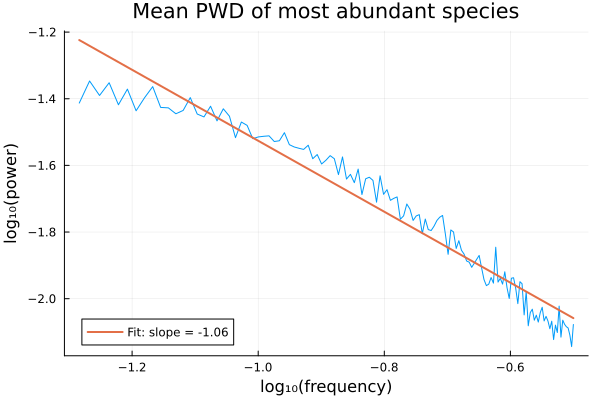

In [155]:
# # Take logs
log_f = log10.(frequencies)
log_S = log10.(mean_S)

# Filter frequencies to avoid bias at too low and too high frequencies
# Essentially the fact the we have linear frequency binning but we compute the slope in log-log space creates problems
# at very low freqs because there are less points and at very high freqs because there are too many points. Moreover these
# methods are exact only in the infinite time case so we need to consider border effects.
mask = (log_f .> -1.3) .& (log_f .< -0.5)
log_f = log_f[mask]
log_S = log_S[mask]

# Put into a DataFrame and fit linear model: log_S ~ log_k
plot_df = DataFrame(log_f=log_f, log_S=log_S)
model = lm(@formula(log_S ~ log_f), plot_df)

# Extract the slope and intercept
coeffs = coef(model)
slope = coeffs[2]
intercept = coeffs[1]

println("Estimated slope: ", slope)
println("Intercept: ", intercept)

# Plot results
plot(log_f, log_S, label=:none, xlabel="log₁₀(frequency)", ylabel="log₁₀(power)", legend=:bottomleft,
    title="Mean PWD of most abundant species")
plot!(log_f, predict(model), label="Fit: slope = $(round(slope, digits=2))", lw=2)

# AFD analysis

In [156]:
# Consider only last point in time for all trajectories (ensemble average)
e_data = y[end,:]
e_data = e_data[e_data .> 0.0]
e_log_data = log.(e_data)
μ_x = mean(e_data)
σ_x = std(e_data)
β = μ_x^2 / σ_x^2

println("μ_x = $μ_x")
println("σ_x = $σ_x")
println("β = $β")

μ_x = 0.00020000000000000015
σ_x = 6.173542342245449e-5
β = 10.49520990641616


In [157]:
# Consider all points of only one trajectory (time average)
t_data = y[:,1]
t_data = t_data[t_data .> 0.0]
t_log_data = log.(t_data)
μ_x = mean(t_data)
σ_x = std(t_data)
β = μ_x^2 / σ_x^2

println("μ_x = $μ_x")
println("σ_x = $σ_x")
println("β = $β")

μ_x = 0.00019218335895046415
σ_x = 6.120545161609455e-5
β = 9.859419505479897


-8.584226983801518


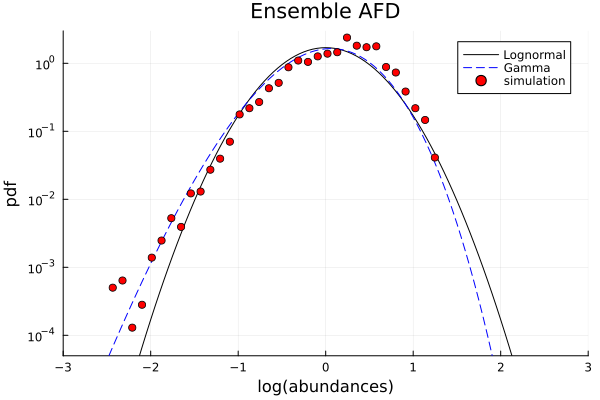

In [158]:
bmin = round(minimum(e_log_data), RoundFromZero)
bmax = round(maximum(e_log_data), RoundFromZero)
Δb = 0.05
fh = FHist.Hist1D(e_log_data, binedges=bmin:Δb:bmax)

# Renormalize the histogram and shift the centers
μ, σ = mean(fh), std(fh)
println(μ)
centers = bincenters(fh)
centers .-= μ
centers ./= sqrt(2 * σ^2)
norm_counts = bincounts(fh) ./ (integral(fh) * Δb)
yy = [10^log(norm_counts[norm_counts.>0.0][i]) for i in eachindex(norm_counts[norm_counts.>0.0])]

centers = centers[norm_counts.>0.0]

# Plot Gaussian distribution
xarr = -3.0:0.05:3.0
lognorm = [10^(-x^2 - log(2 * π * σ^2) / 2) for x in xarr]
plot(xarr, lognorm, color=:black, label="Lognormal", yscale=:log10, yrange=(5e-5, 3), xrange=(-3, 3),
    title="Ensemble AFD", xlabel="log(abundances)", ylabel="pdf")

# Plot Grilli's Gamma distribution
xarr = -15.0:0.05:10.0
g_gamma = [10^(β*x - μ_x/σ_x^2*exp(x) - loggamma(β) + β*log(μ_x/σ_x^2)) for x in (xarr .* sqrt(2 * σ^2) .+ μ)]
plot!(xarr, g_gamma, color=:blue, label="Gamma", linestyle=:dash)

# Fit and plot gamma function
# exp_gamma(x, p) = p[1] .* x .+ p[2] .* exp.(x) .+ p[3]
# p0 = [1.0, 1.0, 1.0]  # Initial guess for the parameters
# fit = curve_fit(exp_gamma, centers, log.(norm_counts[norm_counts.>0.0]), p0)
# p_fit = fit.param

# α, θ, s = p_fit[1], -1/p_fit[2], p_fit[3]
# s_th = -(loggamma(α) + α * log(abs(θ))) / sqrt(2 * σ^2)
# println("α = $α")
# println("β = $β")
# println("Δs = $(abs(s - s_th))")

# xarr = -3.0:0.05:3.0
# fitted_y = exp_gamma(xarr, p_fit)
# gamma_fitted = [10^(fy) for fy in fitted_y]
# plot!(xarr, gamma_fitted, color=:green, label="Gamma (fitted)", linestyle=:dashdot)

# Plot the histogram as a scatter plot
scatter!(centers, yy, color=:red, label="simulation")
# savefig("./Images/exp_growth.png")

-8.622062423500614


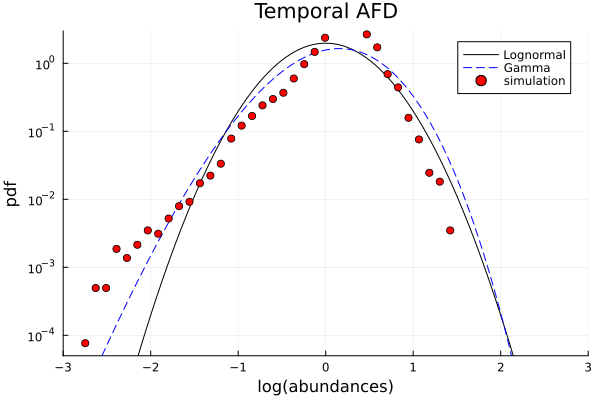

In [159]:
bmin = round(minimum(t_log_data), RoundFromZero)
bmax = round(maximum(t_log_data), RoundFromZero)
Δb = 0.05
fh = FHist.Hist1D(t_log_data, binedges=bmin:Δb:bmax)

# Renormalize the histogram and shift the centers
μ, σ = mean(fh), std(fh)
println(μ)
centers = bincenters(fh)
centers .-= μ
centers ./= sqrt(2 * σ^2)
norm_counts = bincounts(fh) ./ (integral(fh) * Δb)
yy = [10^log(norm_counts[norm_counts.>0.0][i]) for i in eachindex(norm_counts[norm_counts.>0.0])]

centers = centers[norm_counts.>0.0]

# Plot Gaussian distribution
xarr = -3.0:0.05:3.0
lognorm = [10^(-x^2 - log(2 * π * σ^2) / 2) for x in xarr]
plot(xarr, lognorm, color=:black, label="Lognormal", yscale=:log10, yrange=(5e-5, 3), xrange=(-3, 3),
    title="Temporal AFD", xlabel="log(abundances)", ylabel="pdf")

# Plot Grilli's Gamma distribution
xarr = -15.0:0.05:10.0
g_gamma = [10^(β*x - μ_x/σ_x^2*exp(x) - loggamma(β) + β*log(μ_x/σ_x^2)) for x in (xarr .* sqrt(2 * σ^2) .+ μ)]
plot!(xarr, g_gamma, color=:blue, label="Gamma", linestyle=:dash)

# Fit and plot gamma function
# exp_gamma(x, p) = p[1] .* x .+ p[2] .* exp.(x) .+ p[3]
# p0 = [1.0, 1.0, 1.0]  # Initial guess for the parameters
# fit = curve_fit(exp_gamma, centers, log.(norm_counts[norm_counts.>0.0]), p0)
# p_fit = fit.param

# α, θ, s = p_fit[1], -1/p_fit[2], p_fit[3]
# s_th = -(loggamma(α) + α * log(abs(θ))) / sqrt(2 * σ^2)
# println("α = $α")
# println("β = $β")
# println("Δs = $(abs(s - s_th))")

# xarr = -3.0:0.05:3.0
# fitted_y = exp_gamma(xarr, p_fit)
# gamma_fitted = [10^(fy) for fy in fitted_y]
# plot!(xarr, gamma_fitted, color=:green, label="Gamma (fitted)", linestyle=:dashdot)

# Plot the histogram as a scatter plot
scatter!(centers, yy, color=:red, label="simulation")
# savefig("./Images/exp_growth.png")

# MAD analysis

NaN


┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194


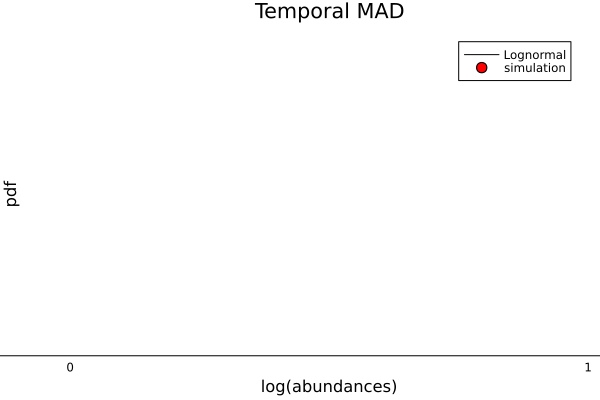

┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils ~/.julia/packages/PlotUtils/dVEMd/src/ticks.jl:194


In [160]:
mean_data = [mean(log.(y[:,i][y[:,i] .> 0.0])) for i in 1:length(y[1,:])]

bmin = round(minimum(mean_data), RoundFromZero)
bmax = round(maximum(mean_data), RoundFromZero)
Δb = 0.05
fh = FHist.Hist1D(mean_data, binedges=bmin:Δb:bmax)

# Renormalize the histogram and shift the centers
μ, σ = mean(fh), std(fh)
println(μ)
centers = bincenters(fh)
centers .-= μ
centers ./= sqrt(2 * σ^2)
norm_counts = bincounts(fh) ./ (integral(fh) * Δb)
yy = [10^log(norm_counts[norm_counts.>0.0][i]) for i in eachindex(norm_counts[norm_counts.>0.0])]

centers = centers[norm_counts.>0.0]

# Plot Gaussian distribution
xarr = -3.0:0.05:3.0
lognorm = [10^(-x^2 - log(2 * π * σ^2) / 2) for x in xarr]
plot(xarr, lognorm, color=:black, label="Lognormal", yscale=:log10,
    title="Temporal MAD", xlabel="log(abundances)", ylabel="pdf")

# Plot the histogram as a scatter plot
scatter!(centers, yy, color=:red, label="simulation")
# savefig("./Images/exp_growth.png")